In [1]:
import torch
import torchvision
import pandas as pd
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import tqdm 
import copy
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [2]:
# These are all of the files you are given
df_tr = pd.read_csv("kaggle-download/train.csv")

In [3]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [4]:
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [5]:
from datetime import datetime
def parse_time(x):

  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [6]:
import math

In [7]:
def fillos(x):
    if x['CALL_TYPE'] == 'B':
        if type(x['ORIGIN_STAND']) == None:
            return -1
        else:
            return x['ORIGIN_STAND']
    if x['CALL_TYPE'] == 'A':
        return 0
    else:
        return -1

In [8]:
df_tr['OS_F'] = df_tr.apply(fillos,axis=1)

In [9]:
df_tr['OS_F'].value_counts()

-1.0     528019
 0.0     364770
 15.0     80241
 57.0     50882
 9.0      34818
          ...  
 41.0       506
 43.0       493
 8.0        381
 5.0         53
 48.0         7
Name: OS_F, Length: 65, dtype: int64

In [10]:
ct = pd.get_dummies(df_tr['CALL_TYPE'])
ct.columns = ['ct_A','ct_B','ct_C']

In [11]:
stan = pd.get_dummies(df_tr['OS_F'])

In [12]:
cols = ['YR','MON','DAY','HR','WK','ct_A','ct_B','ct_C']+list(stan.columns)

In [13]:
df_feat = pd.concat([df_tr,ct,stan],axis=1)
X = df_feat[cols].to_numpy().astype(float)
y = df_feat['LEN'].to_numpy().astype(float)

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

In [16]:
device = torch.device('cpu')

In [17]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)

In [18]:
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1).to(device)

In [19]:
model = nn.Sequential(
    nn.Linear(73, 144),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.BatchNorm1d(144),
    nn.Linear(144, 18),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.BatchNorm1d(18),
    nn.Linear(18, 1),
).to(device)

In [20]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [21]:
from torch.optim.lr_scheduler import StepLR 
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [22]:
save = {'w':None,'history':[],'mse':np.inf}

In [23]:
n_epochs = 50   # number of epochs to run
batch_size = 256  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

In [24]:
best_mse = save['mse']  # init to infinity
best_weights = save['w']
history_train = []
history_test = []

In [25]:
#batch_index_history = []

In [26]:
for epoch in tqdm.tqdm(range(n_epochs)):
    model.train()
    bar = tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True)
    current_batch = []
    for start in bar:
        # take a batch
        X_batch = X[start:start+batch_size]
        #current_batch += list(range(start,start+batch_size))
        #batch_index_history += [np.arange(start, start + batch_size)]
        y_batch = y[start:start+batch_size]
        #y_batch_history += [y_batch]
        # forward pass
        y_pred = model(X_batch)
        a = y_pred.cpu().detach().numpy().transpose()[0]
        loss = loss_fn(y_pred, y_batch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
    # evaluate accuracy at end of each epoch
    #scheduler.step()
    #batch_index_history += [np.array(current_batch)]
    #train_pred = model(X)
    #history_train.append(float(loss_fn(train_pred, y)))
    model.eval()
    #y_pred = model(X_test)
    #mse = loss_fn(y_pred, y_test)
    #mse = float(mse)
    #history_test.append(mse)
    #if mse < best_mse:
    #    best_mse = mse
    #    best_weights = copy.deepcopy(model.state_dict())

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [08:31<00:00, 10.24s/it]


In [27]:
SE = {}
for i in range(len(X)):
    pred = model(X[i].unsqueeze(0))
    try:
        SE[i] = int(loss_fn(pred, y[i]))
    except RuntimeError as e:
        print(i)#len(preds), len(y_batch))

C:\Users\Jimmy\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [28]:
highest_MSE_samples = list(pd.Series(SE).nlargest(10).index)
highest_MSE_samples

[1093727,
 1492417,
 578581,
 224510,
 147121,
 385819,
 182829,
 1199139,
 1003876,
 369196]

In [34]:
df_feat

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,...,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0,63.0
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,...,0,0,0,0,0,0,0,0,0,0
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,...,0,0,0,0,0,0,0,0,0,0
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,...,0,0,0,0,0,0,0,0,0,0
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,...,0,0,0,0,0,0,0,0,0,0
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710665,1404171463620000698,C,NaN,NaN,20000698,1404171463,A,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",465,...,0,0,0,0,0,0,0,0,0,0
1710666,1404171367620000670,C,NaN,NaN,20000670,1404171367,A,False,"[[-8.610138,41.140845],[-8.610174,41.140935],[...",435,...,0,0,0,0,0,0,0,0,0,0
1710667,1388745716620000264,C,NaN,NaN,20000264,1388745716,A,False,[],0,...,0,0,0,0,0,0,0,0,0,0
1710668,1404141826620000248,B,NaN,12.0,20000248,1404141826,A,False,"[[-8.630712,41.154885],[-8.63073,41.154813],[-...",915,...,0,0,0,0,0,0,0,0,0,0


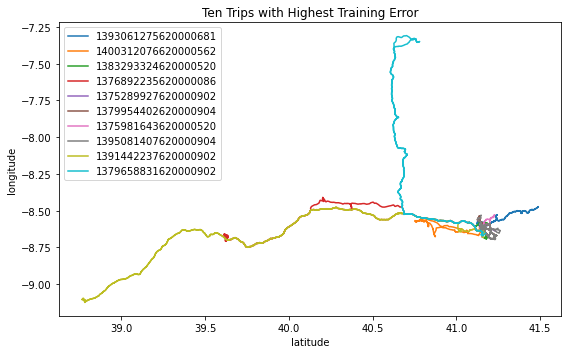

In [35]:
TRIP_IDs = []
plt.figure(figsize=(15*.6, 9*.6))
for i in highest_MSE_samples:
    TRIP_IDs.append(df_feat.iloc[i]['TRIP_ID'])
    df = pd.DataFrame(eval(df_feat.iloc[i]['POLYLINE']))
    plt.plot(df[1],df[0])
plt.legend(TRIP_IDs)
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Ten Trips with Highest Training Error')
plt.show()